# Particle transports with ocean currents

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, jit
%config InlineBackend.figure_formats = ['svg'] # Makes the plots svg (visually better)

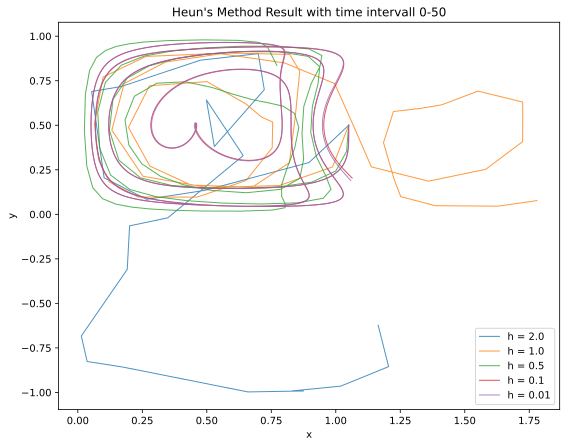

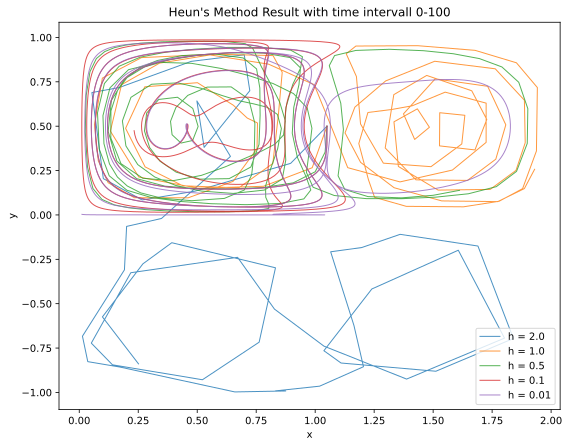

In [86]:
# oppgave 1a
epsilon = 0.25
w = 1
A = 0.1
x_0 = np.array([1.05, 0.5])
h = np.array([2, 1, 0.5, 0.1, 0.01])

@jit
def a(t, epsilon, w):
    return epsilon * np.sin(w*t)

@jit
def b(t, epsilon, w):
    return 1 - 2 * epsilon * np.sin(w*t)

@jit
def f(x, t):
    return a(t, epsilon, w) * x**2 + b(t, epsilon, w) * x

@jit
def x_dot(x_vec, t, A, epsilon, w):
    v_x = - np.pi * A * np.sin(np.pi * f(x_vec[0],t)) * np.cos(np.pi * x_vec[1])
    v_y = np.pi * A * np.cos(np.pi * f(x_vec[0], t)) * np.sin(np.pi * x_vec[1]) * (a(t, epsilon, w) * 2 * x_vec[0] + b(t, epsilon, w))
    return np.array([v_x, v_y])

@jit
def heuns_method(t, h, epsilon, w, A, x_0):
    x_arr = np.zeros((len(t), 2))
    x_arr[0] = x_0
    for i in range(len(t)-1):
        k_1 = x_dot(x_arr[i], t[i], A, epsilon, w)
        k_2 = x_dot(x_arr[i] + k_1 * h, t[i] + h, A, epsilon, w)
        x_arr[i+1] = x_arr[i] + h/2 * (k_1 + k_2)
    
    return x_arr[:, 0], x_arr[:, 1]

plt.figure(figsize=(9,7))
for i in range(len(h)):
    t = np.arange(0, 50, h[i])
    x, y = heuns_method(t, h[i], epsilon, w, A, x_0)
    plt.plot(x, y, label=f"h = {h[i]}", alpha=0.8, lw=1, markersize=4)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Heun\'s Method Result with time intervall 0-50')
plt.legend()
plt.show()

plt.figure(figsize=(9,7))
for i in range(len(h)):
    t = np.arange(0, 100, h[i])
    x, y = heuns_method(t, h[i], epsilon, w, A, x_0)
    plt.plot(x, y, label=f"h = {h[i]}", alpha=0.8, lw=1, markersize=4)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Heun\'s Method Result with time intervall 0-100')
plt.legend()
plt.show()

In [ ]:
# oppgave 1b

